<a href="https://colab.research.google.com/github/Emmanuel461/Sowing_harvest_predictions/blob/main/Modelado_siembra_2022_SAR_k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de siembra año 2022




In [ ]:
# Instalación de dependencias necesarias
!pip install geopandas rasterio torchsummary tifffile imagecodecs gdal rasterstats pandas openpyxl torchsummary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 882.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Importar las librerías necesarias
import os
import numpy as np
import torch
import rasterio
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from rasterio import features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from torchsummary import summary
from shapely.geometry import box

# Rutas de archivos
shapefile_path = '/content/drive/MyDrive/TF_data/DataIn/Parcelas_poligono.geojson'
image_folder_path = '/content/drive/MyDrive/TF_data/SAR_images'  # Carpeta con las imágenes
coregistered_folder = '/content/sample_data'  # Carpeta para las imágenes corregistradas

# Leer el GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Definir fechas de siembra
sowing_dates = {
    1: '27/09/2022',
    2: '23/09/2022',
    3: '28/09/2022',
    4: '25/08/2022',
    5: '17/09/2022'
}

# harvest_dates = {
#     1: '30/11/2022',
#     2: '15/12/2022',
#     3: '09/12/2022',
#     4: '15/12/2022',
#     5: '16/12/2022'
# }


# 2023
# sowing_dates = {
#     1: '30/08/2023',
#     2: '15/09/2023',
#     3: '15/09/2023',
#     4: '15/09/2023',
#     5: '15/09/2023'
# }

# Define harvest dates
# harvest_dates = {
#     1: '28/11/2023',
#     2: '12/12/2023',
#     3: '28/11/2023',
#     4: '12/12/2023',
#     5: '12/12/2023'
# }

# Convert sowing dates to days from a base date
base_date = datetime(2022, 7, 1)
sowing_dates_days = {loc_id: (datetime.strptime(date_str, '%d/%m/%Y') - base_date).days for loc_id, date_str in sowing_dates.items()}

# Convert the `sowing_dates_days` dictionary into a DataFrame for joining
sowing_dates_df = pd.DataFrame(list(sowing_dates_days.items()), columns=['location_id', 'sowing_date_days'])

# Ensure both 'location_id' columns are of the same type
gdf['location_id'] = gdf['location_id'].astype(int)

# Perform a join between the `GeoDataFrame` and the `sowing_dates_df` to add labels
gdf = gdf.merge(sowing_dates_df, on='location_id', how='left')

# Verify the join was performed correctly
print(gdf.head())  # Asegurar que las etiquetas están correctamente asignadas

# Load the list of image paths (.tif or .tiff)
image_paths = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.tif', '.tiff'))])

# Function to filter images by a date range
def filter_images_by_date_range(image_paths, start_date, end_date):
    filtered_paths = []
    for path in image_paths:
        filename = os.path.basename(path)  # Obtener el nombre del archivo
        filename_no_ext, _ = os.path.splitext(filename)  # Eliminar la extensión .tif

        parts = filename_no_ext.split('_')  # Dividir por guiones bajos (_)
        if len(parts) >= 7:
            part5 = parts[6]
            file_date_str = part5[:8]
            try:
                file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
                file_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
                # Only include if the date is within the range
                if start_date <= file_date <= end_date:
                    filtered_paths.append(path)
            except ValueError:
                print(f"Error al extraer la fecha del archivo {filename}")
                continue
        else:
            print(f"Formato de nombre de archivo incorrecto: {filename}")
    return filtered_paths

# Function to coregister images
def coregister_image_to_reference(src_image, reference_image, output_image):
    """
    This function reprojects `src_image` to align with the grid of `reference_image`.
    """
    with rasterio.open(reference_image) as ref:
        # Obtener la transformación, ancho y alto de la imagen de referencia
        transform, width, height = calculate_default_transform(
            ref.crs, ref.crs, ref.width, ref.height, *ref.bounds
        )

        # Update the metadata of the output image with that of the reference
        kwargs = ref.meta.copy()
        kwargs.update({
            'crs': ref.crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject the source image to the reference image's system
        with rasterio.open(src_image) as src:
            with rasterio.open(output_image, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=ref.crs,
                        resampling=Resampling.cubic  # Usamos interpolación cúbica
                    )
    print(f"Imagen {src_image} corregistrada con éxito a {output_image}")

# Buscar bandas por nombre
def select_band_by_name(src, band_names, target_band_names):
    """
    Select bands that match the target band names.
    """
    band_indices = []
    for target_band_name in target_band_names:
        if target_band_name in band_names:
            band_index = band_names.index(target_band_name) + 1  # rasterio usa índices 1-based
            band_indices.append(band_index)
        else:
            print(f"La banda '{target_band_name}' no se encontró en el archivo. Bandas disponibles: {band_names}")
            return None
    return src.read(band_indices)

# Function to rasterize geometries in the raster grid
def mask_image_with_geometries(image, geometries, transform):
    """
    Applies a mask to the image based on the geometries and counts the pixels touching the geometry.
    """
    # Use rasterize with all_touched=True to include all pixels touching the geometries
    mask = features.rasterize(
        [(geom, 1) for geom in geometries],
        out_shape=(image.shape[1], image.shape[2]),
        transform=transform,
        fill=0,
        all_touched=True  # Asegurar que se incluyan todos los píxeles que toquen la geometría
    )

    masked_image = np.where(mask == 1, image, -9999)
    pixel_count = np.sum(mask == 1)

    print(f"Se encontraron {pixel_count} píxeles dentro o tocando la geometría.")
    return masked_image, pixel_count

# Process full sequence of images and add Julian day band
def load_sequence_images(image_paths, gdf, target_band_names=['dias_julianos', 'Stokes2_g2', 'Stokes2_g0', 'entropy', 'entropy_shannon_norm', 'Stokes2_DoLP'], base_date=datetime(2022, 7, 1)):
    sequence = []
    pixel_counts = []
    labels = []  # Aquí almacenamos las etiquetas asociadas a cada polígono
    all_geometries = gdf['geometry']

    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None, None, None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extract the date from the image file name
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)
        parts = filename_no_ext.split('_')

        if len(parts) < 7:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        part5 = parts[6]
        file_date_str = part5[:8]
        try:
            file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
            image_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
            julian_days = (image_date - base_date).days
            print(f"Días julianos calculados: {julian_days} para la imagen {filename}")
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Open the image with rasterio and handle the bands
        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)
            if all(band_name is None for band_name in band_names):
                print(f"Las bandas del archivo {filename} no tienen nombres. Asignando nombres predefinidos.")
                band_names = target_band_names[1:]

            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Create a band for Julian days
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenate the Julian day band with the selected bands
                stacked_bands = np.vstack((julian_band, selected_bands))

                # Use the unified mask function
                masked_bands, pixel_count = mask_image_with_geometries(stacked_bands, all_geometries, src.transform)

                pixel_counts.append(pixel_count)
                sequence.append(masked_bands)

                # Obtener las etiquetas de las geometrías tocadas
                for index, geom in gdf.iterrows():
                    if geom.geometry.intersects(box(*src.bounds)):  # Verifica si la geometría intersecta con la imagen
                        label = geom['sowing_date_days']
                        labels.append(label)

            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        print(f"Secuencias cargadas con la banda 'dias_julianos'.")
        print(f"Conteo de píxeles por geometría: {pixel_counts}")
        return np.stack(sequence, axis=0), pixel_counts, labels
    else:
        print("No se pudo cargar ninguna imagen.")
        return None, None, None


# Define the date range to load images (July 1, 2022 to February 1, 2023)
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 1, 30)

# Filter the images within the date range
image_paths_in_range = sorted(filter_images_by_date_range(image_paths, start_date, end_date))

# Coregister all images using the first one as reference
reference_image_path = image_paths_in_range[0]
coregistered_image_paths = []
for image_path in image_paths_in_range:
    output_image_path = os.path.join(coregistered_folder, os.path.basename(image_path))
    coregister_image_to_reference(image_path, reference_image_path, output_image_path)
    coregistered_image_paths.append(output_image_path)

# Load and mask the coregistered images
X_sequences, pixel_counts, y_labels = load_sequence_images(coregistered_image_paths, gdf)

# Verify the shape of X_sequences and the labels
if X_sequences is not None:
    print(f"Shape de las secuencias: {X_sequences.shape}")
    print(f"Etiquetas (labels): {y_labels}")
    print(f"Conteo de píxeles por geometría: {pixel_counts}")
else:
    print("No se cargaron secuencias.")



   location_id  area_ha   area_m2  polygon_id  \
0            3   0.0140   140.182           1   
1            4   0.0588   587.821           2   
2            1   0.0417   417.453           3   
3            5   0.1239  1239.167           4   
4            2   0.1210  1209.867           5   

                                            geometry  sowing_date_days  
0  MULTIPOLYGON (((-16.45202 12.24534, -16.452 12...                89  
1  MULTIPOLYGON (((-16.44906 12.24442, -16.44908 ...                55  
2  MULTIPOLYGON (((-16.44367 12.24355, -16.44364 ...                88  
3  MULTIPOLYGON (((-16.44028 12.2485, -16.44031 1...                78  
4  MULTIPOLYGON (((-16.44472 12.24445, -16.44472 ...                84  
Imagen /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif corregistrada con éxito a /content/sample_data/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0

In [ ]:
# Configure the dispositive to use in the process of modeling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

In [ ]:
# Initialize a matrix for the labels
labeled_image = np.full(X_sequences.shape[2:], -1, dtype=np.float32)

# Get the spatial reference from one of the images
with rasterio.open(image_paths_in_range[0]) as src:
    out_meta = src.meta.copy()
    out_transform = src.transform

height, width = labeled_image.shape
location_image = np.full((height, width), np.nan)
# Initialize labeled_image with -1 (value indicating no label)
labeled_image = np.full((height, width), -1, dtype=np.float32)

# Iterate over the geometries and assign labels
for idx, row in gdf.iterrows():
    loc_id = row['location_id']
    sowing_date = row['sowing_date_days']
    parcel_geometry = [row['geometry']]

    # Create a mask for the parcel geometry
    mask_array = rasterio.features.geometry_mask(
        parcel_geometry,
        out_shape=(height, width),
        transform=out_transform,
        invert=True,
        all_touched=True
    )

    # Assign the sowing date to the pixels of the parcel
    labeled_image[mask_array] = sowing_date
    location_image[mask_array] = loc_id

# Check if there are NaN values
print(f"Hay NaNs en labeled_image: {np.isnan(labeled_image).any()}")
print(f"Hay NaNs en X_sequences: {np.isnan(X_sequences).any()}")


Hay NaNs en labeled_image: False
Hay NaNs en X_sequences: False


In [ ]:
# Assuming X_sequences has the shape (n_images, n_bands, height, width)
# Create a mask of valid data for each pixel across all images and bands
valid_data_mask = np.all(X_sequences != -9999, axis=(0,1))  # Shape: (height, width)

# Verify how many pixels are valid across all images
num_valid_data_pixels = np.sum(valid_data_mask)
print(f"Número de píxeles con datos válidos en todas las imágenes y bandas: {num_valid_data_pixels}")

Número de píxeles con datos válidos en todas las imágenes y bandas: 101


In [ ]:
num_labeled_pixels = np.sum((labeled_image != -1) & (~np.isnan(labeled_image)))
print(f"Número total de píxeles etiquetados: {num_labeled_pixels}")



Número total de píxeles etiquetados: 101


In [ ]:
unique_values, counts = np.unique(labeled_image[(labeled_image != -1) & (~np.isnan(labeled_image))], return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Etiqueta: {value}, Frecuencia: {count}")


Etiqueta: 55.0, Frecuencia: 19
Etiqueta: 78.0, Frecuencia: 27
Etiqueta: 84.0, Frecuencia: 28
Etiqueta: 88.0, Frecuencia: 17
Etiqueta: 89.0, Frecuencia: 10


In [ ]:
import numpy as np

# Obtener los valores únicos en labeled_image, excluyendo -9999
unique_values = np.unique(labeled_image[labeled_image != -9999])

# Imprimir los valores únicos
print("Valores únicos en labeled_image (excluyendo -9999):", unique_values)

# Contar la frecuencia de cada valor único
for value in unique_values:
    count = np.sum(labeled_image == value)
    print(f"Valor: {value}, Frecuencia: {count}")

Valores únicos en labeled_image (excluyendo -9999): [-1. 55. 78. 84. 88. 89.]
Valor: -1.0, Frecuencia: 47623
Valor: 55.0, Frecuencia: 19
Valor: 78.0, Frecuencia: 27
Valor: 84.0, Frecuencia: 28
Valor: 88.0, Frecuencia: 17
Valor: 89.0, Frecuencia: 10


In [ ]:
# Rearrange data for the 3D CNN
num_images, num_bands, height, width = X_sequences.shape

# Rearrange to shape (n_bands, n_images, height, width)
X = X_sequences.transpose(1, 0, 2, 3)  # (n_bandas, n_imágenes, alto, ancho)
X = X.astype(np.float32)

# Prepare the labels
y = labeled_image.astype(np.float32)  # (alto, ancho)

# Replace NaNs in y with -1
y[np.isnan(y)] = -1

# Replace NaNs in X_sequences with -1
X_sequences[np.isnan(X_sequences)] = -1

# Rearrange data for the model without patches
num_bands, num_images, height, width = X.shape  # X es de forma (n_bandas, n_imágenes, alto, ancho)

# Flatten X to (n_samples, n_bands, n_images)
X_flat = X.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_samples, n_bandas, n_imágenes)

# Flatten y to (n_samples,)
y_flat = y.flatten()  # (n_samples,)

# Flatten location_image to (n_samples,)
location_flat = location_image.flatten()

# Create a mask to filter pixels with valid labels
valid_mask = ~np.isnan(y_flat) & (y_flat != -1)

# Filter X, y, and location_id using the mask
X_flat_valid = X_flat[valid_mask]  # (n_valid_samples, n_bandas, n_imágenes)
y_flat_valid = y_flat[valid_mask]  # (n_valid_samples,)
location_flat_valid = location_flat[valid_mask]  # (n_valid_samples,)

# Verify that there are valid data
if X_flat_valid.shape[0] == 0:
    raise ValueError("No se encontraron píxeles con etiquetas válidas. Verifica tus datos.")

print(f"Shape de X_flat_valid: {X_flat_valid.shape}")
print(f"Shape de y_flat_valid: {y_flat_valid.shape}")
print(f"Shape de location_flat_valid: {location_flat_valid.shape}")


Shape de X_flat_valid: (101, 6, 18)
Shape de y_flat_valid: (101,)
Shape de location_flat_valid: (101,)


In [ ]:
print(y_flat_valid)

[78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78.
 78. 78. 78. 78. 78. 78. 78. 78. 78. 89. 89. 89. 89. 89. 89. 89. 89. 89.
 89. 55. 55. 55. 55. 55. 55. 55. 55. 55. 84. 84. 84. 84. 84. 84. 55. 55.
 55. 55. 55. 84. 84. 84. 84. 84. 84. 55. 55. 55. 55. 55. 84. 84. 84. 84.
 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 88. 88. 88. 88. 88. 88.
 88. 88. 88. 88. 88. 88. 88. 88. 88. 88. 88.]


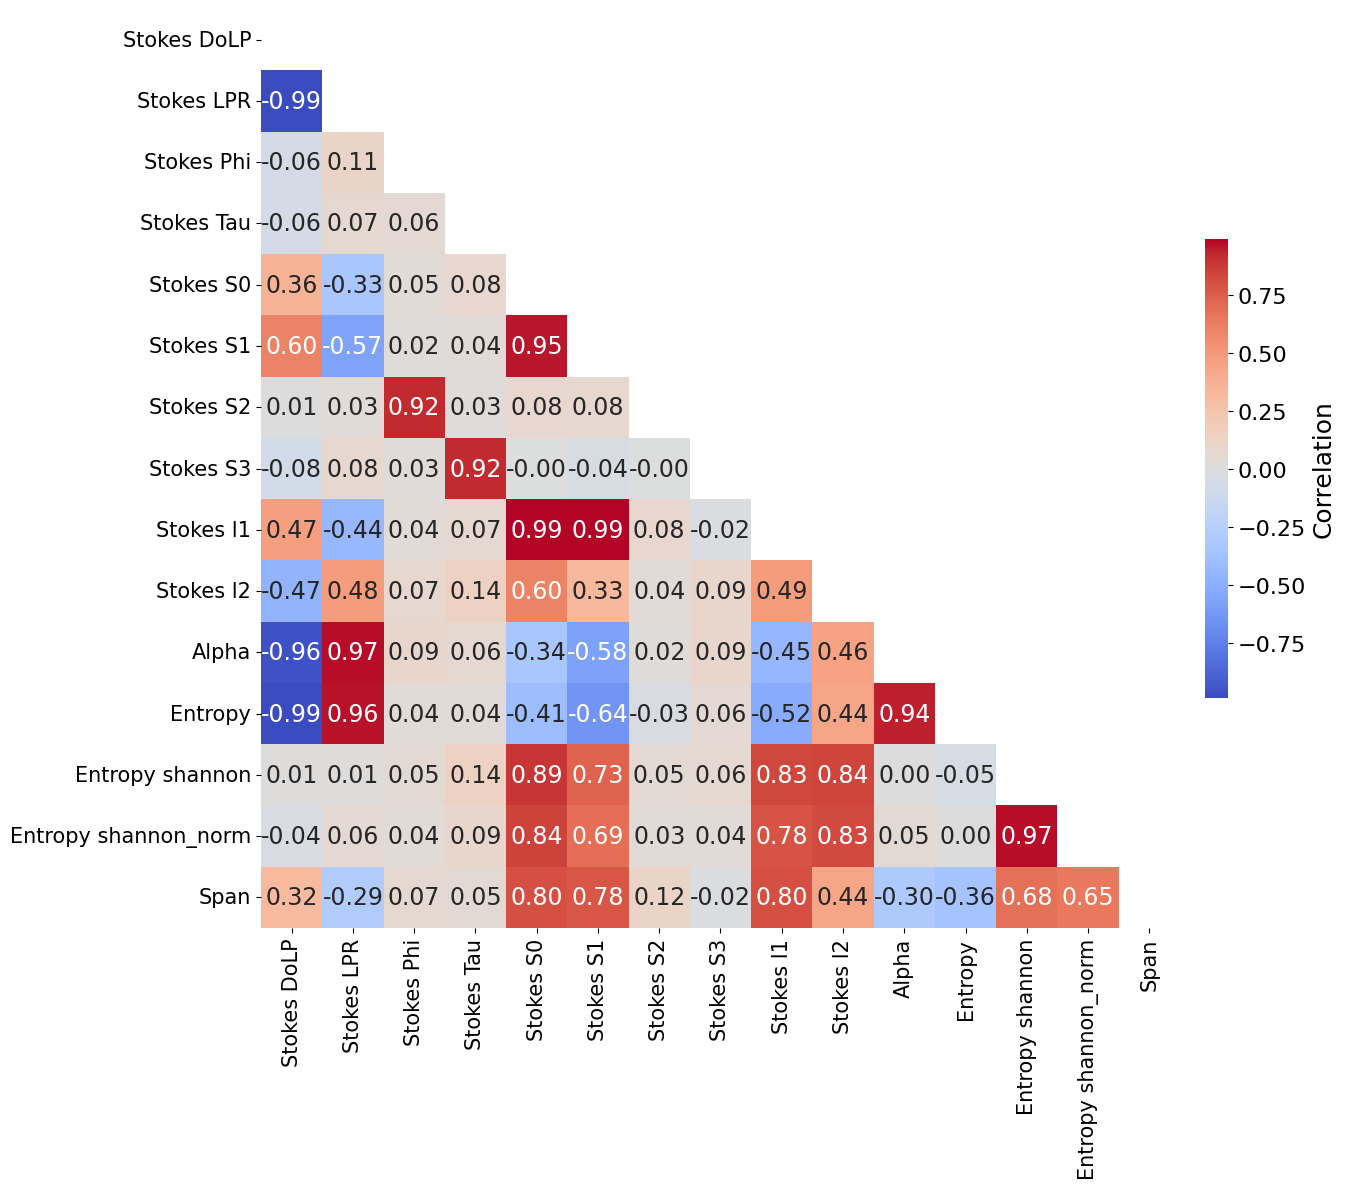

Pares de bandas altamente correlacionadas (umbral > 0.95):
Stokes DoLP y Stokes LPR: correlación = -0.9885
Stokes DoLP y Alpha: correlación = -0.9603
Stokes DoLP y Entropy: correlación = -0.9886
Stokes LPR y Alpha: correlación = 0.9720
Stokes LPR y Entropy: correlación = 0.9648
Stokes S0 y Stokes S1: correlación = 0.9535
Stokes S0 y Stokes l1: correlación = 0.9910
Stokes S1 y Stokes l1: correlación = 0.9851
Entropy shannon y Entropy shannon_norm: correlación = 0.9733


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Suponiendo que ya tenemos las siguientes variables definidas:
# - X_sequences: con forma (n_imágenes, n_bandas, alto, ancho)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas, n_imágenes)

# 'dias_julianos', 'Stokes2_DoLP', 'Stokes2_LPR', 'Stokes2_Phi', 'Stokes2_Tau', 'Stokes2_g0', 'Stokes2_g1', 'Stokes2_g2', 'Stokes2_g3', 'Stokes2_l1', 'Stokes2_l2', 'alpha', 'entropy', 'entropy_shannon', 'entropy_shannon_norm', 'span'


# Update the band labels
band_labels = ['dias_julianos', 'Stokes DoLP', 'Stokes LPR', 'Stokes Phi', 'Stokes Tau', 'Stokes S0', 'Stokes S1', 'Stokes S2', 'Stokes S3', 'Stokes l1', 'Stokes l2', 'Alpha', 'Entropy', 'Entropy shannon', 'Entropy shannon_norm', 'Span']

# Rearrange X_flat_valid to have bands as columns
n_valid_pixels, n_bandas, n_imágenes = X_flat_valid.shape

# Transpose and flatten to obtain (n_valid_pixels * n_imágenes, n_bandas)
X_for_corr = X_flat_valid.transpose(0, 2, 1).reshape(-1, n_bandas)

# Replace invalid values (-9999) with NaN
X_for_corr[X_for_corr == -9999] = np.nan

# Assume that 'dias_julianos' is in the corresponding column in X_for_corr and its label in band_labels
# Find the index of 'dias_julianos' in the band labels
julian_day_index = band_labels.index('dias_julianos')

# Remove the 'dias_julianos' column in X_for_corr and its label in band_labels
X_for_corr_filtered = np.delete(X_for_corr, julian_day_index, axis=1)
band_labels_filtered = [label for i, label in enumerate(band_labels) if i != julian_day_index]

# Replace invalid values (-9999) with NaN
X_for_corr_filtered[X_for_corr_filtered == -9999] = np.nan

# Remove rows with NaN values in any band
valid_mask = ~np.isnan(X_for_corr_filtered).any(axis=1)
X_for_corr_valid = X_for_corr_filtered[valid_mask]

# Calculate the Pearson correlation matrix between the filtered bands
correlation_matrix = np.corrcoef(X_for_corr_valid, rowvar=False)

# Create a mask to show only the lower half of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualize the correlation matrix with the applied mask
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=band_labels_filtered, yticklabels=band_labels_filtered, center=0, square=True,
            annot_kws={"size": 17},  # Correlation number size
            cbar_kws={'label': 'Correlation', 'shrink': 0.5, 'orientation': 'vertical', 'pad': 0.02})  # Colorbar adjustments

# Additional adjustments for element sizes
plt.title('', fontsize=18)  # Figure title
plt.xticks(rotation=90, fontsize=15)  # X-axis label size and rotation
plt.yticks(rotation=0, fontsize=15)   # Y-axis label size

# Adjust the colorbar label size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Colorbar number size
cbar.set_label('Correlation', fontsize=18)  # Colorbar label

plt.tight_layout()  # Layout adjustment

# Show the plot
plt.show()

# Define correlation threshold
correlation_threshold = 0.95

# Find pairs of bands with high correlation
highly_correlated_pairs = []
for i, j in itertools.combinations(range(len(band_labels_filtered)), 2):
    corr_value = correlation_matrix[i, j]
    if abs(corr_value) > correlation_threshold:
        highly_correlated_pairs.append((i, j, corr_value))

# Print highly correlated bands
print("Pares de bandas altamente correlacionadas (umbral > 0.95):")
for i, j, corr_value in highly_correlated_pairs:
    print(f"{band_labels_filtered[i]} y {band_labels_filtered[j]}: correlación = {corr_value:.4f}")


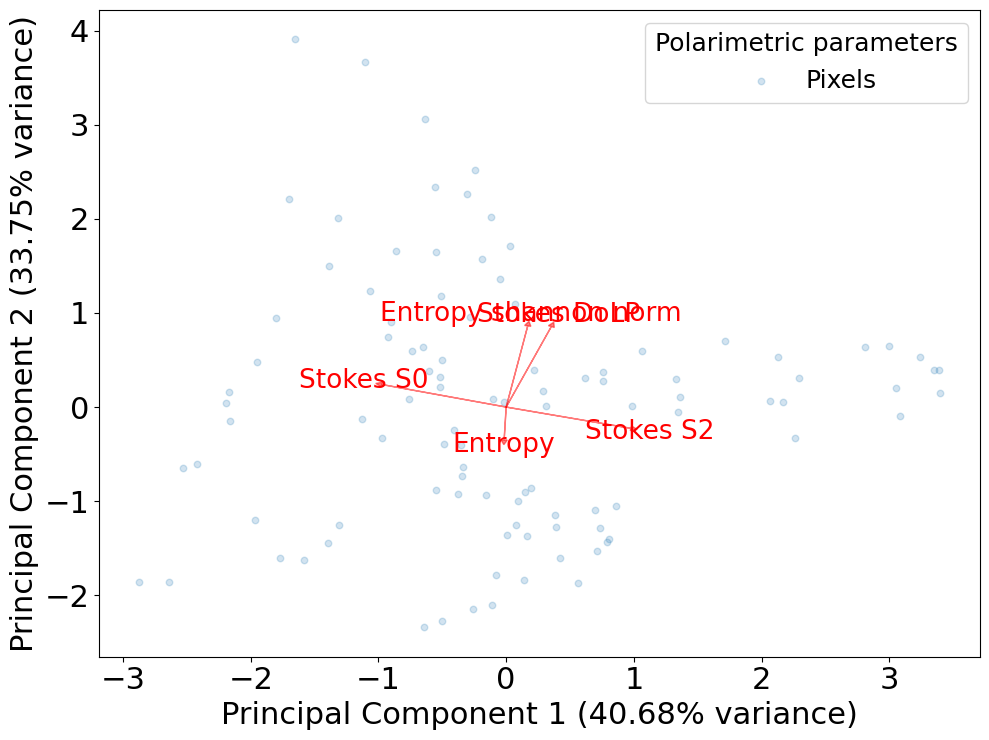

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you already have the following variables defined:
# - X_flat_valid: input data corresponding to valid pixels, shape (n_valid_pixels, n_bands, n_images)
# - y_flat_valid: labels corresponding to valid pixels, shape (n_valid_pixels,)

band_labels = ['Stokes S2', 'Stokes S0', 'Entropy', 'Entropy shannon norm', 'Stokes DoLP']

# Step 1: Average the bands over time to reduce dimensionality
# This will give us a matrix of shape (n_valid_pixels, n_bands)
X_mean_time = np.mean(X_flat_valid, axis=2)  # Average along the time dimension

# Ensure X_mean_time has the same number of columns as the size of band_labels
X_mean_time = X_mean_time[:, 1:]  # Remove the first column corresponding to 'Julian Days'

# Step 2: Remove samples with missing or invalid values
valid_mask = ~np.isnan(X_mean_time).any(axis=1) & (X_mean_time != -9999).all(axis=1)
X_mean_time_valid = X_mean_time[valid_mask]

# Step 3: Scale the data before PCA (zero mean and unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mean_time_valid)

# Step 4: Perform PCA
n_components = 2  # For the biplot, we need two principal components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Get the percentage of variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Step 5: Obtain the loadings of the original variables
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Step 6: Create the biplot with size adjustments
plt.figure(figsize=(10, 7.5))

# Plot the scores (projections of the samples on the principal components)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.2, s=22, label='Pixels')

# Add vectors of the original variables (loadings)
for i, (loading_x, loading_y) in enumerate(loadings):
    plt.arrow(0, 0, loading_x, loading_y, color='red', alpha=0.5, head_width=0.05, head_length=0.05)
    plt.text(loading_x * 1.15, loading_y * 1.15, band_labels[i], color='red', ha='center', va='center', fontsize=19)

# Update axis labels to include the percentage of explained variance
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2f}% variance)', fontsize=22)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2f}% variance)', fontsize=22)

# Adjust title, legend, and other visual elements
plt.title('', fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(title='Polarimetric parameters', fontsize=18, title_fontsize='18', loc='upper right')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
# 1. Dataset

# Reemplaza estas variables con tus datos reales

# Definir el dataset personalizado
class PixelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convertir a tensores y ajustar dimensiones para que sean compatibles con el modelo
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        X = X.unsqueeze(-1).unsqueeze(-1)  # Agregar dimensiones espaciales ficticias (1x1)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

# Definir el Modelo CNN 3D Pixel a Pixel sin capas de normalización
class CNN3DModelPixelwise(nn.Module):
    def __init__(self, num_bands, num_images, dropout_rate=0.1):
        super(CNN3DModelPixelwise, self).__init__()

        # Capas convolucionales ajustadas para dimensiones espaciales de 1x1
        self.conv1 = nn.Conv3d(in_channels=num_bands, out_channels=32,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv1b = nn.Conv3d(in_channels=32, out_channels=32,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2b = nn.Conv3d(in_channels=64, out_channels=64,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        # Capa de convolución temporal para condensar la información temporal
        self.conv_temporal = nn.Conv3d(in_channels=64, out_channels=64,
                                       kernel_size=(num_images, 1, 1))
        # Capa final de convolución
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1)

        # Dropout para la regularización
        self.dropout = nn.Dropout3d(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)

        x = torch.relu(self.conv1b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv_temporal(x))
        x = self.dropout(x)

        x = self.conv3(x)
        x = x.squeeze()
        return x

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Step 2: Split data into training and test sets, specifying the group to leave out
X = X_flat_valid
y = y_flat_valid
groups = location_flat_valid.astype(int)

# Specify the group to leave out as the test set
test_group = 3  # Change this value to the group you want to leave out

# Create masks to separate the data
train_mask = groups != test_group
test_mask = groups == test_group

# Split the data into training and test sets according to the masks
X_train = X[train_mask]
y_train = y[train_mask]
groups_train = groups[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]

print(f"Número de muestras en entrenamiento: {len(X_train)}")
print(f"Número de muestras en prueba (grupo {test_group}): {len(X_test)}")
print(f"Grupos en entrenamiento: {np.unique(groups_train)}")
print(f"Grupos en prueba: {np.unique(groups_test)}")


Usando el dispositivo: cpu
Número de muestras en entrenamiento: 91
Número de muestras en prueba (grupo 3): 10
Grupos en entrenamiento: [1 2 4 5]
Grupos en prueba: [3]


In [ ]:
from sklearn.model_selection import GroupKFold
# Define the hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.08, 0.05, 0.1, 0.001],
    'dropout_rate': [0.01, 0.1],
    'optimizer': ['Adam', 'Adagrad']
}

grid = list(ParameterGrid(param_grid))

# Get the unique values of y_train and y_test
unique_y_train = np.unique(y_train)
unique_y_test = np.unique(y_test)

print("Valores únicos en y_train:", unique_y_train)
print("Valores únicos en y_test:", unique_y_test)

# K-fold cross-validation on the training data
unique_groups = np.unique(groups_train)
n_splits = min(4, len(unique_groups))
random_state = 42


Valores únicos en y_train: [55. 78. 84. 88.]
Valores únicos en y_test: [89.]


In [ ]:
gkf = GroupKFold(n_splits=n_splits)

# Variables to store the best hyperparameters and score
best_params = None
best_score = np.inf  # Because we want to minimize the RMSE

for params in grid:
    print(f"\nEvaluando hiperparámetros: {params}")
    fold_metrics = []

    # Configure the current hyperparameters
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    for fold, (train_idx_fold, val_idx_fold) in enumerate(gkf.split(X_train, y_train, groups=groups_train)):
        print(f"  Fold {fold + 1}/{n_splits}")
        print(f"    Número de muestras en entrenamiento: {len(train_idx_fold)}")
        print(f"    Número de muestras en validación: {len(val_idx_fold)}")

        # Ensure that the validation set is not empty
        if len(val_idx_fold) == 0:
            print(f"    Fold {fold + 1} omitido por falta de muestras en validación.")
            continue

        # Split the data into training and validation
        X_fold_train, X_fold_val = X_train[train_idx_fold], X_train[val_idx_fold]
        y_fold_train, y_fold_val = y_train[train_idx_fold], y_train[val_idx_fold]

        # Normalize the data based on X_fold_train
        num_bands = X_fold_train.shape[1]
        num_images = X_fold_train.shape[2]

        means = np.mean(X_fold_train, axis=(0, 2))
        stds = np.std(X_fold_train, axis=(0, 2))
        stds[stds == 0] = 1  # Avoid division by zero

        def normalize_data(X, means, stds):
            return (X - means[np.newaxis, :, np.newaxis]) / stds[np.newaxis, :, np.newaxis]

        X_fold_train_norm = normalize_data(X_fold_train, means, stds)
        X_fold_val_norm = normalize_data(X_fold_val, means, stds)

        # Create datasets and dataloaders
        train_dataset = PixelDataset(X_fold_train_norm, y_fold_train)
        val_dataset = PixelDataset(X_fold_val_norm, y_fold_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Define the model with the current hyperparameters
        model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

        # Define the loss function and optimizer
        criterion = nn.L1Loss()
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

        # Train the model on X_fold_train
        num_epochs = 30  # Adjust as necessary
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set
        all_val_preds = []
        all_val_trues = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_val_preds.extend(preds)
                all_val_trues.extend(trues)

        # Calculate metrics for the validation set
        if len(all_val_trues) > 0:
            val_rmse = np.sqrt(mean_squared_error(all_val_trues, all_val_preds))
            val_mae = mean_absolute_error(all_val_trues, all_val_preds)
            val_bias = np.mean(np.array(all_val_preds) - np.array(all_val_trues))
            val_pbias = 100 * np.sum(np.array(all_val_preds) - np.array(all_val_trues)) / np.sum(np.array(all_val_trues))
        else:
            val_rmse = np.nan
            val_mae = np.nan
            val_bias = np.nan
            val_pbias = np.nan

        print(f"    RMSE en validación: {val_rmse:.4f}")
        print(f"    MAE en validación: {val_mae:.4f}")
        print(f"    Bias en validación: {val_bias:.4f}")
        print(f"    PBIAS en validación: {val_pbias:.4f}%")

        # Save the metrics for this fold
        fold_metric = {
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_bias': val_bias,
            'val_pbias': val_pbias
        }
        fold_metrics.append(fold_metric)

    # Calculate average metrics across all folds
    mean_metrics = {
        'mean_val_rmse': np.nanmean([m['val_rmse'] for m in fold_metrics]),
        'mean_val_mae': np.nanmean([m['val_mae'] for m in fold_metrics]),
        'mean_val_bias': np.nanmean([m['val_bias'] for m in fold_metrics]),
        'mean_val_pbias': np.nanmean([m['val_pbias'] for m in fold_metrics]),
    }

    # Print average metrics
    print(f"Resultados promedio para los hiperparámetros {params}:")
    print(f"  RMSE promedio en validación: {mean_metrics['mean_val_rmse']:.4f}")
    print(f"  MAE promedio en validación: {mean_metrics['mean_val_mae']:.4f}")
    print(f"  Bias promedio en validación: {mean_metrics['mean_val_bias']:.4f}")
    print(f"  PBIAS promedio en validación: {mean_metrics['mean_val_pbias']:.4f}%")

    # Update the best hyperparameters if necessary
    if mean_metrics['mean_val_rmse'] < best_score:
        best_score = mean_metrics['mean_val_rmse']
        best_params = params

print(f"\nMejores hiperparámetros encontrados: {best_params} con RMSE promedio en validación de {best_score:.4f}")



Evaluando hiperparámetros: {'dropout_rate': 0.01, 'learning_rate': 0.08, 'optimizer': 'Adam'}
  Fold 1/4
    Número de muestras en entrenamiento: 63
    Número de muestras en validación: 28
    RMSE en validación: 17.4016
    MAE en validación: 16.7703
    Bias en validación: -16.7703
    PBIAS en validación: -19.9647%
  Fold 2/4
    Número de muestras en entrenamiento: 64
    Número de muestras en validación: 27
    RMSE en validación: 73.5496
    MAE en validación: 73.5496
    Bias en validación: -73.5496
    PBIAS en validación: -94.2944%
  Fold 3/4
    Número de muestras en entrenamiento: 72
    Número de muestras en validación: 19
    RMSE en validación: 50.6482
    MAE en validación: 50.6482
    Bias en validación: -50.6482
    PBIAS en validación: -92.0877%
  Fold 4/4
    Número de muestras en entrenamiento: 74
    Número de muestras en validación: 17
    RMSE en validación: 9.5947
    MAE en validación: 8.7842
    Bias en validación: -8.7842
    PBIAS en validación: -9.9820%
R

Epoch 1/30, Loss: 60.9814
Epoch 2/30, Loss: 54.0405
Epoch 3/30, Loss: 52.5356
Epoch 4/30, Loss: 48.9109
Epoch 5/30, Loss: 36.4186
Epoch 6/30, Loss: 17.0147
Epoch 7/30, Loss: 12.6166
Epoch 8/30, Loss: 12.8841
Epoch 9/30, Loss: 10.1801
Epoch 10/30, Loss: 10.1258
Epoch 11/30, Loss: 10.2137
Epoch 12/30, Loss: 9.2559
Epoch 13/30, Loss: 9.8572
Epoch 14/30, Loss: 10.6499
Epoch 15/30, Loss: 9.2815
Epoch 16/30, Loss: 8.0556
Epoch 17/30, Loss: 7.8090
Epoch 18/30, Loss: 7.7201
Epoch 19/30, Loss: 7.9354
Epoch 20/30, Loss: 6.9960
Epoch 21/30, Loss: 9.2542
Epoch 22/30, Loss: 4.7140
Epoch 23/30, Loss: 11.5146
Epoch 24/30, Loss: 6.9854
Epoch 25/30, Loss: 5.9719
Epoch 26/30, Loss: 4.2715
Epoch 27/30, Loss: 3.2232
Epoch 28/30, Loss: 8.9643
Epoch 29/30, Loss: 7.0646
Epoch 30/30, Loss: 3.5809

Métricas en el Conjunto de Entrenamiento:
RMSE: 5.0755
MAE: 3.8299
R²: 0.8083
Bias: 3.1121
PBIAS: 4.0442%


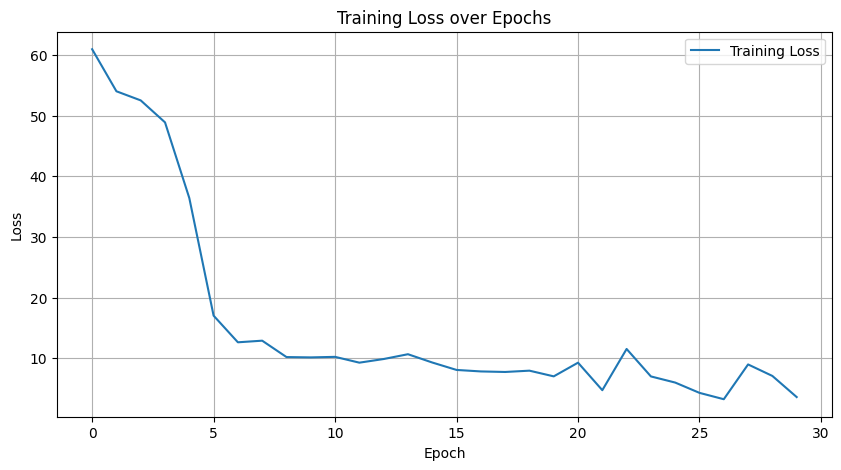

In [ ]:
num_bands = X_train.shape[1]
num_images = X_train.shape[2]

means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
stds[stds == 0] = 1

def normalize_data(X, means, stds):
    return (X - means[np.newaxis, :, :]) / stds[np.newaxis, :, :]

X_train_norm = normalize_data(X_train, means, stds)

# Create the dataset and dataloader for the complete training data
train_dataset = PixelDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Create the model with the best hyperparameters
dropout_rate = 0.01
learning_rate = 0.1
optimizer_name = best_params['optimizer']

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

# Define the loss function and optimizer with the best hyperparameters
criterion = nn.L1Loss()
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 30   # Adjust as necessary
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluate the model on the complete training set
model.eval()
all_train_preds = []
all_train_trues = []

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        all_train_preds.extend(outputs.cpu().numpy())
        all_train_trues.extend(targets.cpu().numpy())

# Calculate metrics on the complete training set
train_mse = mean_squared_error(all_train_trues, all_train_preds)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(all_train_trues, all_train_preds)
train_r2 = r2_score(all_train_trues, all_train_preds)
train_bias = np.mean(np.array(all_train_preds) - np.array(all_train_trues))
train_pbias = 100 * np.sum(np.array(all_train_preds) - np.array(all_train_trues)) / np.sum(np.array(all_train_trues))

print('\nMétricas en el Conjunto de Entrenamiento:')
print(f'RMSE: {train_rmse:.4f}')
print(f'MAE: {train_mae:.4f}')
print(f'R²: {train_r2:.4f}')
print(f'Bias: {train_bias:.4f}')
print(f'PBIAS: {train_pbias:.4f}%')

# Plot the loss function during training
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd

df_results = pd.DataFrame({
    'Valores Observados': all_train_preds,
    'Valores Predichos':  all_train_trues
})
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx'
df_results.to_excel(excel_file_path, index=False)

print(f"Resultados exportados exitosamente a {excel_file_path}")

Resultados exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx


R²: 0.7775
RMSE: 5.0755
MAE: 3.8299
Bias: -3.1121
PBIAS: -3.8870%
Pearson Correlation: 0.9383


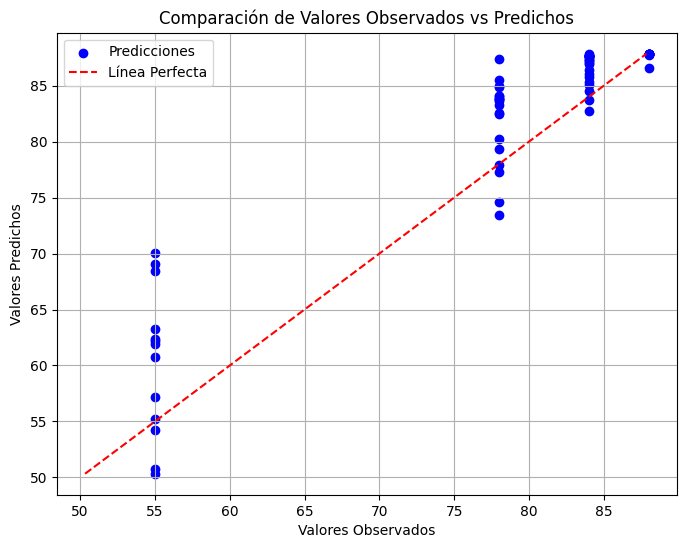

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Specify the path to the Excel file
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx'

# Read the Excel file
df_results = pd.read_excel(excel_file_path)

# Extract observed and predicted values
observed_values = df_results['Valores Observados']
predicted_values = df_results['Valores Predichos']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(observed_values, predicted_values)

# Calculate R²
r2 = r2_score(observed_values, predicted_values)

# Calculate Bias
bias = np.mean(predicted_values - observed_values)

# Calculate PBIAS
pbias = 100 * np.sum(predicted_values - observed_values) / np.sum(observed_values)

# Calculate Pearson Correlation
pearson_corr, _ = pearsonr(observed_values, predicted_values)

# Display the results
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Bias: {bias:.4f}")
print(f"PBIAS: {pbias:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Generate the scatter plot for observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, observed_values, label='Predicciones', color='blue')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', label='Línea Perfecta', linestyle='--')

plt.title('Comparación de Valores Observados vs Predichos')
plt.xlabel('Valores Observados')
plt.ylabel('Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Normalize test data using training data statistics
X_test_norm = normalize_data(X_test, means, stds)

# Create the dataset and dataloader for the test data
test_dataset = PixelDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test data
model.eval()

all_test_predictions = []
all_test_true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        preds = outputs.cpu().numpy()
        trues = targets.cpu().numpy()

        all_test_predictions.extend(preds)
        all_test_true_values.extend(trues)

# Calculate metrics on the test data
mse = mean_squared_error(all_test_true_values, all_test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_test_true_values, all_test_predictions)
r2 = r2_score(all_test_true_values, all_test_predictions)
bias = np.mean(np.array(all_test_predictions) - np.array(all_test_true_values))
pbias = 100 * np.sum(np.array(all_test_predictions) - np.array(all_test_true_values)) / np.sum(np.array(all_test_true_values))


print('\nMétricas en el Conjunto de Prueba:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Bias: {bias:.4f}')
print(f'PBIAS: {pbias:.4f}%')


Métricas en el Conjunto de Prueba:
RMSE: 2.3387
MAE: 1.8109
R²: 0.0000
Bias: -1.8109
PBIAS: -2.0347%


In [ ]:
import pandas as pd

df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_test_predictions).reshape(-1),
    'Valores Predichos': np.array(all_test_true_values).reshape(-1)
})

excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_SAR.xlsx'
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")

Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_SAR.xlsx


In [ ]:
print(all_test_predictions)

[82.82445, 87.7689, 87.61744, 86.890236, 87.819336, 87.81331, 87.714355, 87.85472, 87.846954, 87.74112]


In [ ]:
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'means': means,
    'stds': stds,
    'num_bands': num_bands,
    'num_images': num_images,
    'best_params': best_params
}, model_path)

print(f"\nModelo final guardado en {model_path}")


Modelo final guardado en /content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth


In [ ]:
device = 'cpu'
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth"
model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
means = checkpoint['means']
stds = checkpoint['stds']
num_bands = checkpoint['num_bands']
num_images = checkpoint['num_images']
model.eval()  

<ipython-input-86-82530bbaf700>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CNN3DModelPixelwise(
  (conv1): Conv3d(6, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv1b): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2b): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv_temporal): Conv3d(64, 64, kernel_size=(18, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (dropout): Dropout3d(p=0.1, inplace=False)
)

Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif
Días julianos calculados: 3 para la imagen 1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif
Las bandas del archivo 1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif no tienen nombres. Asignando nombres predefinidos.
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif
Días julianos calculados: 15 para la imagen 1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif
Las bandas del archivo 1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif no tienen nombres. Asignando nombres predefinidos.
Cargando y enmascarando

<ipython-input-87-9da6e79c1e3b>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Imagen predicha guardada en /content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_SAR.tif


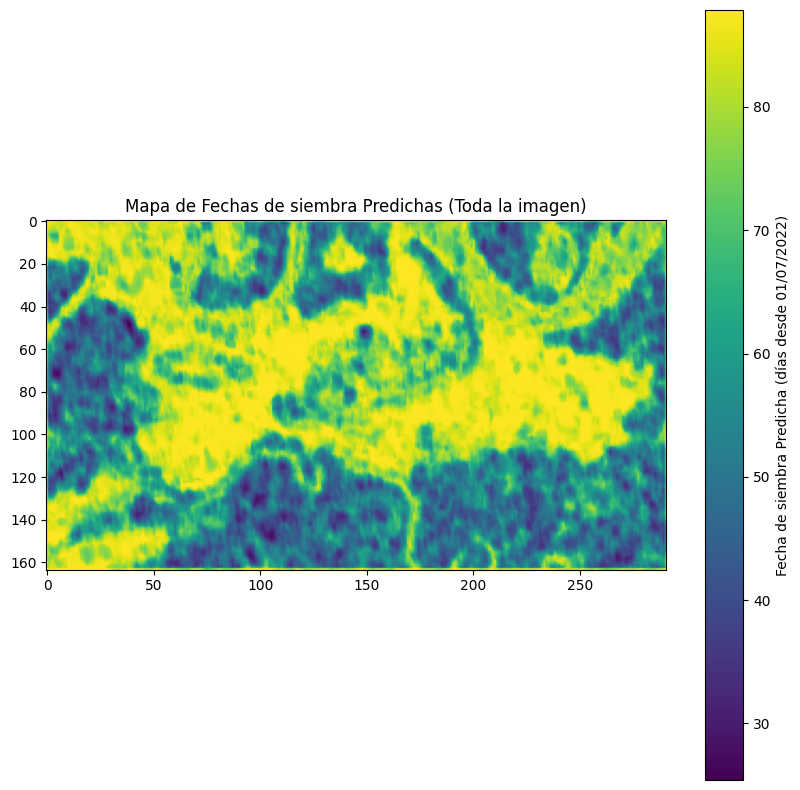

In [ ]:
# Load the complete image for prediction
def load_full_sequence_images(image_paths, target_band_names=['dias_julianos',  'Stokes2_g2', 'Stokes2_g0', 'entropy', 'entropy_shannon_norm', 'Stokes2_DoLP']):
    sequence = []
    pixel_counts = []
    labels = []  # Here we store the labels associated with each polygon
    all_geometries = gdf['geometry']
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extract the image date from the filename (without the .tif extension)
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)
        parts = filename_no_ext.split('_')

        if len(parts) < 7:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        part5 = parts[6]
        file_date_str = part5[:8]
        try:
            file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
            image_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
            julian_days = (image_date - base_date).days
            print(f"Días julianos calculados: {julian_days} para la imagen {filename}")
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Open the image with rasterio and handle the bands
        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)
            if all(band_name is None for band_name in band_names):
                print(f"Las bandas del archivo {filename} no tienen nombres. Asignando nombres predefinidos.")
                band_names = target_band_names[1:]

            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Create a band for Julian days with the same spatial size as the images
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenate the Julian days band with the selected bands
                stacked_bands = np.vstack((julian_band, selected_bands))

                sequence.append(stacked_bands)

            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        return np.stack(sequence, axis=0)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None, None, None


# Prediction over the entire image (using the trained model)
# Load the complete image for prediction
X_full_sequences = load_full_sequence_images(image_paths_in_range)

# Verify that the sequences were loaded
if X_full_sequences is not None:
    print(f"Shape de X_full_sequences: {X_full_sequences.shape}")  # (n_imágenes, n_bandas, alto, ancho)
else:
    raise ValueError("No se pudieron cargar las secuencias de imágenes completas.")

# Reorganize the data to match the model's format
# Transpose to (n_bandas, n_imágenes, alto, ancho)
X_full = X_full_sequences.transpose(1, 0, 2, 3)
X_full = X_full.astype(np.float32)

# Normalize the complete image using the trained model's means and standard deviations
def normalize_dataset(X_data, means, stds):
    return (X_data - means[:, :, np.newaxis, np.newaxis]) / stds[:, :, np.newaxis, np.newaxis]

X_full_norm = normalize_dataset(X_full, means, stds)

# Flatten the spatial dimensions to get a list of pixels
X_full_flat = X_full_norm.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_pixels, num_bands, num_imágenes)

print(f"Shape de X_full_flat: {X_full_flat.shape}")  # (n_pixels, num_bands, num_imágenes)

# Create a Dataset and DataLoader for the full prediction
full_dataset = PixelDataset(X_full_flat, np.zeros(X_full_flat.shape[0]))  # Labels are irrelevant here
full_loader = DataLoader(full_dataset, batch_size=24, shuffle=False)

# Load the trained model
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Apply the trained model to the entire image
all_predictions = []

with torch.no_grad():
    for inputs, _ in full_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.cpu().numpy()
        all_predictions.extend(preds)

# Reconstruct the prediction image
predictions_array = np.array(all_predictions)
height, width = X_full_sequences.shape[2], X_full_sequences.shape[3]
predictions_image = predictions_array.reshape(height, width)

# Save the predicted image
with rasterio.open(image_paths_in_range[0]) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1)

output_path = '/content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_SAR.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(predictions_image, 1)

print(f"Imagen predicha guardada en {output_path}")

# Visualize the predicted image
plt.figure(figsize=(10, 10))
plt.imshow(predictions_image, cmap='viridis')
plt.colorbar(label='Fecha de siembra Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de siembra Predichas (Toda la imagen)')
plt.show()

In [ ]:
# Verificar las dimensiones de las matrices
print("Shape de X_full_sequences:", X_full_sequences.shape)  # (num_times,num_bands height, width)
print("Shape de means:", means.shape)  # (num_bands, num_times)
print("Shape de stds:", stds.shape)    # (num_bands, num_times)


Shape de X_full_sequences: (16, 8, 164, 291)
Shape de means: (8, 16)
Shape de stds: (8, 16)
